# Comparing classifiers in classy colors, code, scikit

Most machine learning problems are classfication problems. From [detecting cat pictures](https://www.wired.com/2015/06/how-googles-new-photos-app-can-tell-cats-from-dogs/) to [choosing what to type next](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), a lot of things in life reduce themselves to a series of choices.

A good guide has lots of practical advice and interesting visual aids. This makes the [classifiers comparison demo](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) extremely cool. Have a look at its [graphic showing off the various classifiers](http://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png) available in scikit-learn.

Nevertheless, the above demo is a little light on practical advice, especially for new users. I've put together a guide that goes into more detail setting up classifiers.

Here is what I cover

1. Generating toy data
    1. **The moons and circles** These are two simple classification problems you can generate in scikit-learn. They will test an algorithm's ability to deal with non-linear class boundaries.
    2. **Preparing convenience functions** Here I write a function I will use throughout the notebook to generate graphs.
    3. **Adding polynomials** scikit-learn makes it easy to generate polynomials from your data.
2. Playing with classifiers and decision boundaries
    1. **Logistic regression** The classic linear classifier, simple but underpowered.
    2. **Decision trees** A model that cuts the data into pieces.
    3. **AdaBoost** A technique for boosting the real-world power of models.
    4. **Random Forests** Another *ensemble* technique for increasing real-world power, but with added tricks.
    5. **Nearest neighbors** A simple approach: imitate similar datapoints.
    5. **Support vector machines** A separating hyperplane, a different way of splitting data.
    6. **Neural networks** A network of neurons that can process data in very complicated ways.
3. Appendix: preparing data for classification
    1. **Code data with a test condition** Assign a datapoint membership in a class if a condition is true.
    2. **Code data by labels** Give datapoints IDs and route them to the right class.

Let's import everything we need.

In [1]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, AdaBoostRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Data generation
from sklearn.datasets import make_classification, make_circles, make_moons
from sklearn.preprocessing import PolynomialFeatures

# Get some ways of evaluating models
from sklearn.metrics import accuracy_score, classification_report

# Who could forget the old friends
import matplotlib.pyplot as plt
import numpy as np

## Generating data for playing with

### The moons and circles

There are two fun datasets to play with using classifiers. They both have non-linear boundaries, so they test the power of the classifiers.

The [`make_moons()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function creates a dataset with interlocking moons, and the [`make_circles()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) function makes one ring contained within another.

We want to create a training set and a validation set so that we can see if the models are overfitting. We also don't want to give the models too much data since that would make them too good.

In [2]:
X, y = make_moons(n_samples=1000, noise=0.3)
#X, y = make_circles(n_samples=1000, noise=0.2)
#X, y = make_classification(n_samples=1000, class_sep=0.5) # If you want more dimensions

X_train = X[:500,]
y_train = np.array(y)[:500]
print(X_train.shape)
print(y_train.shape)

X_valid = X[500:1000,]
y_valid = np.array(y)[500:1000]
print(X_valid.shape)
print(y_valid.shape)

(500, 2)
(500,)
(500, 2)
(500,)


Here is what the data looks like.

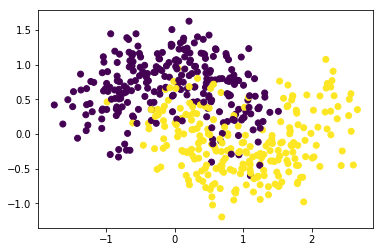

In [3]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)

plt.show()

### Convenience functions

To make our lives easier, we'll create some helper functions to fit and graph various classifiers to the data. I'll describe the functions involved one-by-one.

The main goal of the `decision_boundary()` function below is to plot class probabilities onto a 2D graph, with darker areas favouring one class and lighter areas favouring the other.

The [`np.arange()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.arange.html) function (not to be misread as *arrange*) is the numpy equivalent of the base python [`range()`](https://docs.python.org/3/library/functions.html#func-range). Below we feed it a starting point, an end point, and a value to increment by, and it will return a sequence of floats.

With these two sequences (1D arrays) we can use the [`np.meshgrid()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.meshgrid.html) function to generate a series of coordinates for the model to predict.

I use the `classifier.predict_proba()` function here because I prefer seeing a softer decision boundary rather than a hard one. Some of the classifiers below have sharp boundaries while others don't. The `classifier.predict_proba()` function is available on *nearly* all scikit-learn classifier methods, so it can be used freely with different models.

A good part of the code below comes from the [classifiers example](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

In [4]:
def decision_boundary(X, y, classifier, poly=None, soft=True, size=8, pointer_size=20, show=True, title=None):
    if size:
        plt.figure(figsize=(size, size))
    if title:
        plt.title(title)
    # Setting up the meshgrid coordinates
    xx1_min, xx1_max = X[:,0].min() - .5, X[:,0].max() + .5
    xx2_min, xx2_max = X[:,1].min() - .5, X[:,1].max() + .5
    xx1, xx2 = np.meshgrid(np.arange(xx1_min, xx1_max, 0.01), 
                            np.arange(xx2_min, xx2_max, 0.01))
    # Adding polynomial terms, if desired
    if poly:
        grid_xx = poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()])
    else:
        grid_xx = np.c_[xx1.ravel(), xx2.ravel()]
    # Predicting both probabilities and classes
    if soft:
        Zprobs = classifier.predict_proba(grid_xx)[:, 1].reshape(xx1.shape)
    Zmax = classifier.predict(grid_xx).reshape(xx1.shape)
    # Contour plot, with color or no
    if soft:
        out = plt.contourf(xx1, xx2, Zprobs, cmap=plt.cm.binary, alpha=1.0)
        out = plt.contourf(xx1, xx2, Zmax, cmap=plt.cm.rainbow, alpha=0.1)
    else:
        out = plt.contourf(xx1, xx2, Zmax, cmap=plt.cm.binary, alpha=1.0)
    plt.scatter(X[:,0], X[:,1], c=y, s=pointer_size, cmap=plt.cm.rainbow, alpha=0.5)
    # Don't show plot if the use want to do that own their own
    if show:
        plt.show()

def score_model(classifier, poly=None):
    if poly:
        predict_train = classifier.predict(poly.fit_transform(X_train))
        predict_valid = classifier.predict(poly.fit_transform(X_valid))
    else:
        predict_train = classifier.predict(X_train)
        predict_valid = classifier.predict(X_valid)

    print("train accuracy : {0}".format(accuracy_score(y_train, predict_train)))
    print("valid accuracy : {0}".format(accuracy_score(y_valid, predict_valid)))
    print(classification_report(y_valid, predict_valid))

### Generating polynomials quickly

Scikit-learn offers you the [`PolynomialFeatures()`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) function to make your life easier here. It will transform any numpy input data into a new dataset with interactions and polynomials. You use it by instantiating it first and then feeding it data with `.fit_transform()`.

We have to apply this transformation to the `meshgrid` data being predicted as well, so I went back and added a `poly=` argument to the `decision_boundary` function.

In [5]:
# The default options will give us (1, a, b, a*b, a**2, b**2)
poly3 = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
p3X_train = poly3.fit_transform(X_train)
p3X_valid = poly3.fit_transform(X_valid)

# Here are second-order polynomials
poly2 = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
p2X_train = poly2.fit_transform(X_train)
p2X_valid = poly2.fit_transform(X_valid)

# Here are seventh-order polynomials, for when you really want to overfit
poly7 = PolynomialFeatures(degree=7, interaction_only=False, include_bias=False)
p7X_train = poly7.fit_transform(X_train)
p7X_valid = poly7.fit_transform(X_valid)

## Testing classifiers by visualizing decision boundaries

Now we're ready to test out classifiers. We'll be on the look-out for evaluating how well the models are at fitting non-linear boundaries and also how much they overfit.

### Logistic regression

The [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) fits a decision boundary that is a straight line, which will be "soft" thanks to the logistic/sigmoid the predictions pass through.

Interesting arguments for `LogisticRegression`
* `penalty` can add either L1 or L2 weight penalties
* `class_weight` can automatically balance classes when set to `'balanced'`

If this example is run on the `moons` data, it won't perform terribly; however, the logistic regression will do badly on the `circles` data.

train accuracy : 0.836
valid accuracy : 0.854
             precision    recall  f1-score   support

          0       0.85      0.85      0.85       242
          1       0.86      0.86      0.86       258

avg / total       0.85      0.85      0.85       500



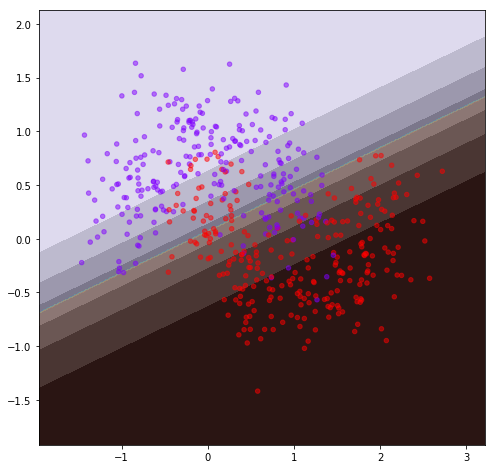

In [6]:
log = LogisticRegression()

log_fit = log.fit(X_train, y_train)

score_model(log)
decision_boundary(X_valid, y_valid, log)

There is one way of fixing this. If we add 2nd and 3rd order polynomials of the $X$ data, the logistic regression will become a lot better at predicting both the `moons` and the `circles` datasets.

When we run the logistic with these, it gets a lot better.

train accuracy : 0.906
valid accuracy : 0.904
             precision    recall  f1-score   support

          0       0.90      0.90      0.90       242
          1       0.90      0.91      0.91       258

avg / total       0.90      0.90      0.90       500



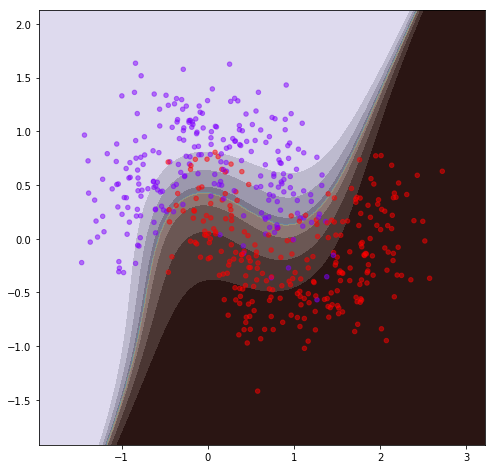

In [7]:
log = LogisticRegression()

log_fit = log.fit(p3X_train, y_train)

score_model(log, poly=poly3)
decision_boundary(X_valid, y_valid, log, poly=poly3)

### Decision trees

[scikit-learn's explanation](http://scikit-learn.org/stable/modules/tree.html) with advantages and disadvantages of decision trees

[Wikipedia article on decision trees](https://en.wikipedia.org/wiki/Decision_tree_learning)

Interesting arguments for `DecisionTreeClassifier`
* `splitter` is `'best'` by default, but can be set to `'random'` which apparently selects the best among a random subset of decisions (similar to RandomForests)
* `max_depth` sets the maximum number of decision levels before stopping, no maximum by default
* `max_leaf_nodes` sets the maximum number of pieces the data is split into, no maximum by default
* `max_features` controls the amount of features that can be used to make a split, no maximum by default

The [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) is an iterative model. They start by slicing the data in two in such a way to best predict the classes. It then splits one of these halves in order to best improve the predictions, and so on. This keeps going until the data is perfectly split: decision trees overfit by default.

You can see this in action by incrementing through the `max_leaf_nodes` argument. It sets the maximum amount of times the tree can split the data.

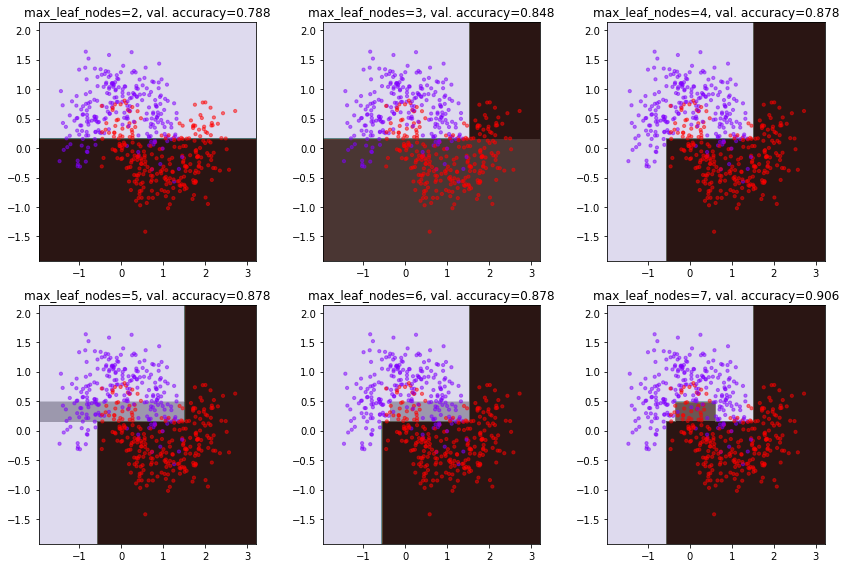

In [8]:
plt.figure(figsize=(12, 8))

for i in range(6):
    _ = DecisionTreeClassifier(max_leaf_nodes=i+2)
    _fit = _.fit(X_train, y_train)
    plt.subplot(2, 3, i+1)
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    decision_boundary(X_valid, y_valid, _, size=None, pointer_size=10, 
                      show=False, title="max_leaf_nodes={0}, val. accuracy={1}".format(i+2, valid_accuracy))

plt.tight_layout()
plt.show()

When you run the `DecisionTreeClassifier` without a maximum, it will keep splitting the data until it's completely separated. You can see this in the `train_accuracy` below: it's at 100%.

train accuracy : 1.0
valid accuracy : 0.864
             precision    recall  f1-score   support

          0       0.86      0.86      0.86       242
          1       0.87      0.86      0.87       258

avg / total       0.86      0.86      0.86       500



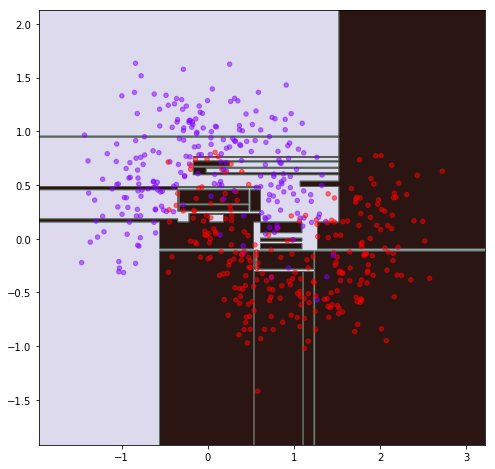

In [9]:
tree = DecisionTreeClassifier()

tree_fit = tree.fit(X_train, y_train)

score_model(tree)
decision_boundary(X_valid, y_valid, tree)

The decision trees work by feature selection: they choose a few features to split by. This doesn't apply above since we only have two variables, but it can come into play when we add polynomials.

(You can change this behaviour in scikit-learn, if you want.)

With the 2nd order polynomial terms, the decision tree can now choose curved boundaries. You might have to re-run this a few times to see them.

train accuracy : 1.0
valid accuracy : 0.858
             precision    recall  f1-score   support

          0       0.85      0.86      0.85       242
          1       0.86      0.86      0.86       258

avg / total       0.86      0.86      0.86       500



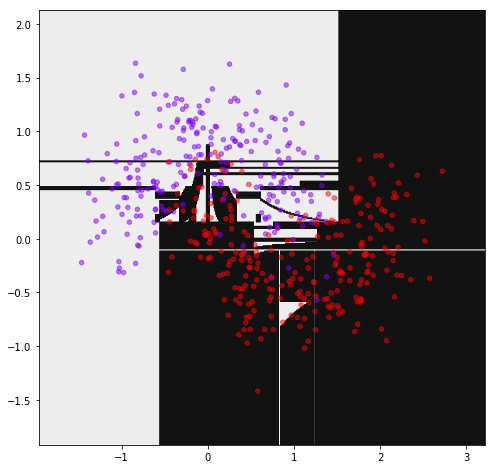

In [10]:
tree = DecisionTreeClassifier()

tree_fit = tree.fit(p2X_train, y_train)

score_model(tree, poly=poly2)
decision_boundary(X_valid, y_valid, tree, poly=poly2, soft=False)

### Adaboost

[scikit-learn description of AdaBoost](http://scikit-learn.org/stable/modules/ensemble.html#adaboost)

[Wikipedia article on AdaBoost](https://en.wikipedia.org/wiki/AdaBoost)

One way of making trees overfit less is the [`AdaBoostClassifier()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), which by default "boosts" the `DecisionTreeClassifier` (you can boost other models if you want). Technically though, you're boosting the data, not the model: this language makes more intuitive sense since boosted data weakens an overly-strong model (overfitting of data).

(Searching on the internet indicates that AdaBoost is supposed to do the opposite, increase fit. Perhaps there's a difference with how AdaBoost is implemented in scikit-learn?)

Interesting arguments for `AdaBoostClassifier`
* `base_estimator` is the "weak classifier" to use, by default this is a decision tree
* `n_estimators` is the amount of weak classifiers to use, 50 by default

The AdaBoost algorithm works by running the "weak classifier" on a sampled dataset first. It will keep doing this for each estimator, but will "adapt" itself each time by adjusting sampling weights.

This means that the path taken by the ensemble of classifiers will end up being different than the path taken by a lone classifier (it'll be tempted to split the data differently).

The classifier will overfit less since it won't have full and reliable access to the training data. By only seeing pieces of it, it'll only be able to overfit bits and pieces. When the "weak classifiers" are combined, they'll end up doing reasonably well (but will fit the data less well).

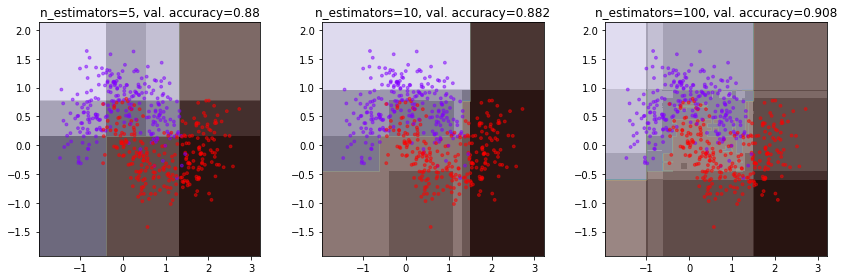

In [11]:
plt.figure(figsize=(12, 4))

for n, i in zip((5, 10, 100), (1, 2, 3)):
    _ = AdaBoostClassifier(n_estimators=n)
    _fit = _.fit(X_train, y_train)
    plt.subplot(1, 3, i)
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    decision_boundary(X_valid, y_valid, _, soft=True, size=None, pointer_size=8, 
                      show=False, title="n_estimators={0}, val. accuracy={1}".format(n, valid_accuracy))

plt.tight_layout()
plt.show()

#### AdaBoost with the logistic regression

You can change the `base_estimator` to whatever you want, as long as it's a classifier. But the point of AdaBoost is to help control overfitting, so it won't help `LogisticRegression`.

As you can see below, there is an improvement, but it doesn't beat the non-boosted logistic regression. Notice the higher confidence in the non-boosted model.

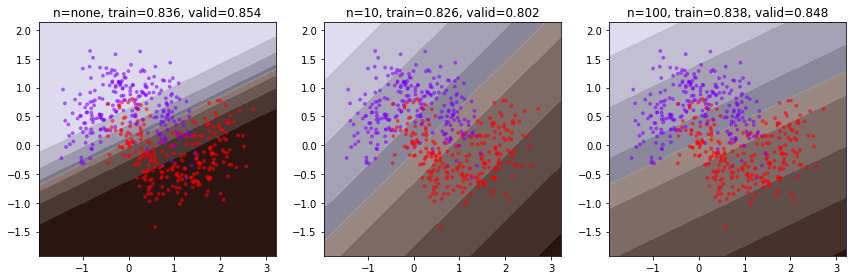

In [12]:
plt.figure(figsize=(12, 4))

for n, i in zip(("none", 10, 100), (1, 2, 3)):
    if n == "none":
        _ = LogisticRegression()
    else:
        _ = AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=n)
    _fit = _.fit(X_train, y_train)
    plt.subplot(1, 3, i)
    train_accuracy = accuracy_score(y_train, _.predict(X_train))
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    decision_boundary(X_valid, y_valid, _, soft=True, size=None, pointer_size=8, 
                      show=False, title="n={0}, train={1}, valid={2}".format(n, train_accuracy, valid_accuracy))

plt.tight_layout()
plt.show()

However, even if we use 7th order polynomials, AdaBoost won't necessarily help validation accuracy. I've only seen it happen once in the examples below.

It seems that AdaBoost is best suited for models that overfit more than the logistic can.

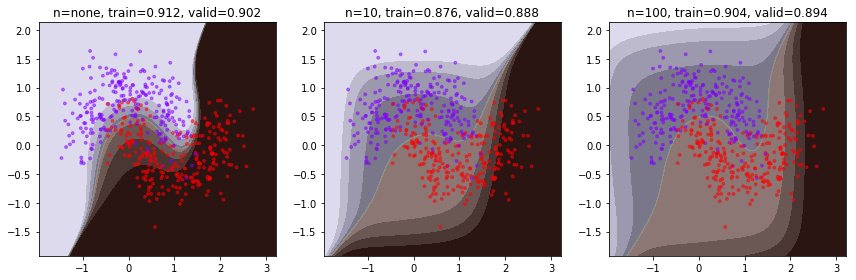

In [13]:
plt.figure(figsize=(12, 4))

for n, i in zip(("none", 10, 100), (1, 2, 3)):
    if n == "none":
        _ = LogisticRegression()
    else:
        _ = AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=n)
    _fit = _.fit(p7X_train, y_train)
    plt.subplot(1, 3, i)
    train_accuracy = accuracy_score(y_train, _.predict(p7X_train))
    valid_accuracy = accuracy_score(y_valid, _.predict(p7X_valid))
    decision_boundary(X_valid, y_valid, _, poly=poly7, soft=True, size=None, pointer_size=8, 
                      show=False, title="n={0}, train={1}, valid={2}".format(n, train_accuracy, valid_accuracy))

plt.tight_layout()
plt.show()

### Random Forests

[scikit-learn's guide on random forests](http://scikit-learn.org/stable/modules/ensemble.html#forest)

[Wikipedia article on random forests](http://scikit-learn.org/stable/modules/ensemble.html#forest)

The [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) method is similar to Adaboost in that they're both ensemble methods: they combine a lot of decision tree classifiers together. Random forests are different in that they repeatedly "bootstrap" sample the data and then aggregate the resulting models. Also, their decision trees *randomly* subset features at each node to further reduce overfitting (this is a non-default option in DecisionTree classifiers).

Interesting options in `RandomForestClassifier` (it shares some arguments with `DecisionTreeClassifier`
* `n_estimators` is the number of trees to combine together into the forest
* `n_jobs` is by default 1 but you can set it to -1 to use all your CPU's cores

As you can see below, adding a lot of estimators ends up helping validation accuracy.

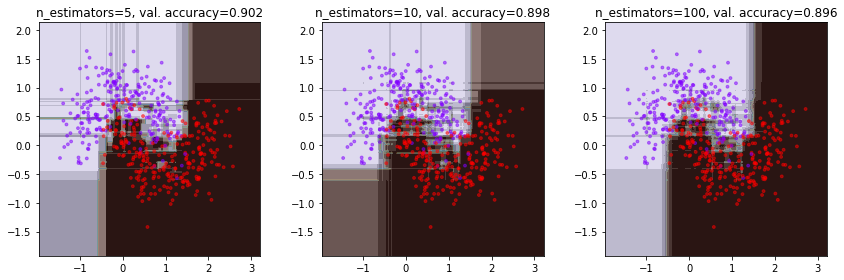

In [14]:
plt.figure(figsize=(12, 4))

for n, i in zip((5, 10, 100), (1, 2, 3)):
    _ = RandomForestClassifier(n_estimators=n, n_jobs=-1)
    _fit = _.fit(X_train, y_train)
    plt.subplot(1, 3, i)
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    decision_boundary(X_valid, y_valid, _, soft=True, size=None, pointer_size=8, 
                      show=False, title="n_estimators={0}, val. accuracy={1}".format(n, valid_accuracy))

plt.tight_layout()
plt.show()

The maximum *depth* of the trees can also be adjusted, but as you can see, the forests resist overfitting.

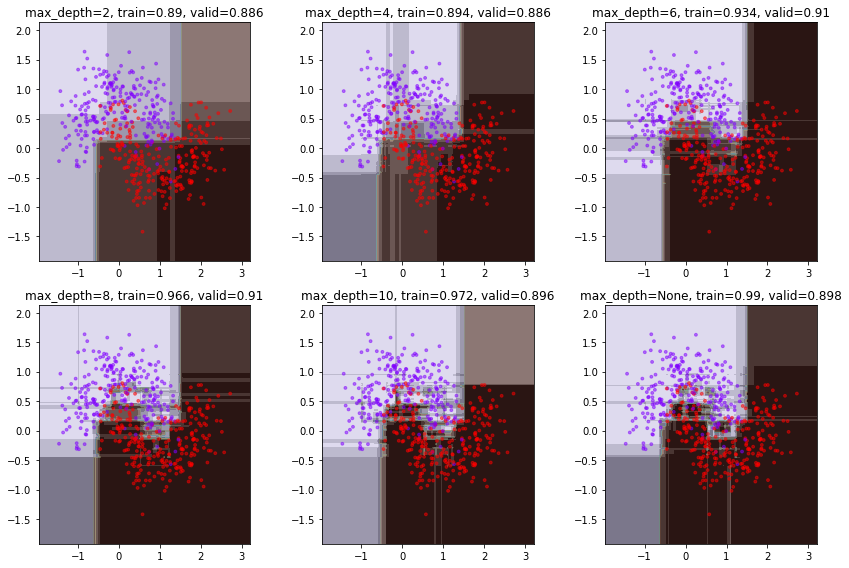

In [15]:
plt.figure(figsize=(12, 8))

for n, i in zip((2, 4, 6, 8, 10, None), (1, 2, 3, 4, 5, 6)):
    _ = RandomForestClassifier(max_depth=n, n_estimators=10, n_jobs=-1)
    _fit = _.fit(X_train, y_train)
    plt.subplot(2, 3, i)
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    train_accuracy = accuracy_score(y_train, _.predict(X_train))
    decision_boundary(X_valid, y_valid, _, soft=True, size=None, pointer_size=8, 
                      show=False, title="max_depth={0}, train={1}, valid={2}".format(n, train_accuracy, valid_accuracy))

plt.tight_layout()
plt.show()

### Nearest neighbors

[scikit-learn's introduction to nearest neighbors](http://scikit-learn.org/stable/modules/neighbors.html)

[Wikipedia article on k-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

The [`KNeighborsClassifier`](scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) is technically not a supervised learning algorithm, despite appearances. It works by simply finding the $k$ most similar datapoints in its training dataset and returning their average.

Interesting arguments for `KNeighborsClassifier`
* `n_neighbors` sets the amount of neighbors to use as donors for the prediction
* `weights` controls how the neighbors are weighted. It gives the choice of `'uniform'` and `'distance'`, but you can also use some custom function.


The average can either be uniform (equally weighted) or weighted by the inverse of the distance between points. When the average is inversely weighted, the KNN model will favor the closest datapoints more than distant ones.

train accuracy : 1.0
valid accuracy : 0.876
             precision    recall  f1-score   support

          0       0.86      0.88      0.87       242
          1       0.89      0.87      0.88       258

avg / total       0.88      0.88      0.88       500



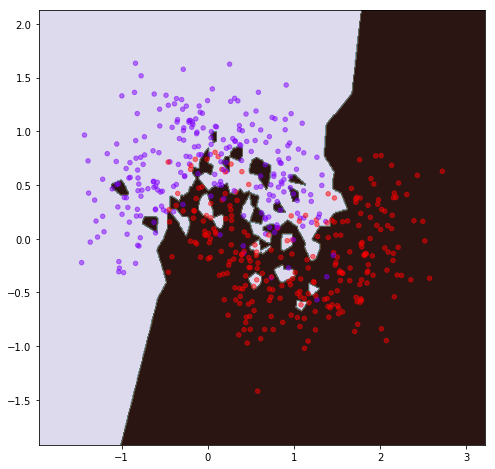

In [16]:
knn1 = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

knn1_fit = knn1.fit(X_train, y_train)

score_model(knn1)
decision_boundary(X_valid, y_valid, knn1)

train accuracy : 0.916
valid accuracy : 0.91
             precision    recall  f1-score   support

          0       0.88      0.94      0.91       242
          1       0.94      0.88      0.91       258

avg / total       0.91      0.91      0.91       500



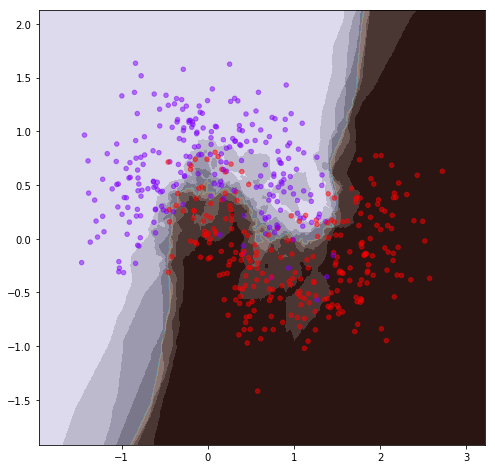

In [17]:
knn10 = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)

knn10_fit = knn10.fit(X_train, y_train)

score_model(knn10)
decision_boundary(X_valid, y_valid, knn10)

As we increase the number of neighbors, you can see that the decision boundary gets too smooth. This can be helped by weighing the neighbor distances, but this isn't a guaranteed fix.

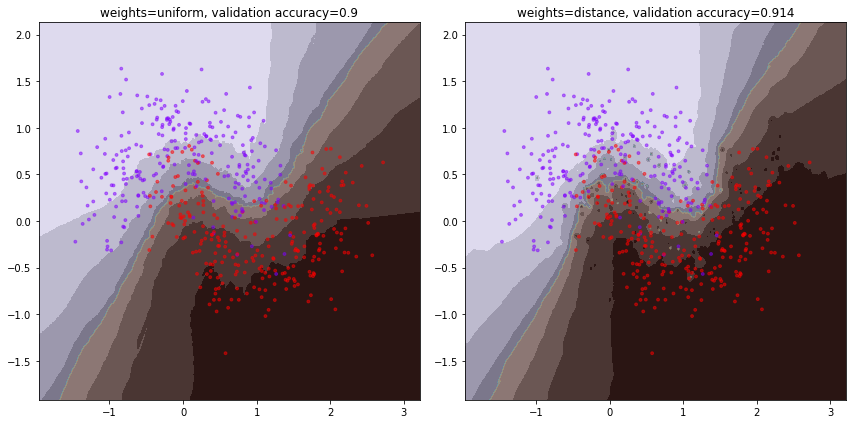

In [18]:
plt.figure(figsize=(12, 6))

for w, i in zip(('uniform', 'distance'), (1, 2)):
    _ = KNeighborsClassifier(n_neighbors=100, weights=w, n_jobs=-1)
    _fit = _.fit(X_train, y_train)
    plt.subplot(1, 2, i)
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    decision_boundary(X_valid, y_valid, _, size=None, pointer_size=8, 
                      show=False, title="weights={0}, validation accuracy={1}".format(w, valid_accuracy))

plt.tight_layout()
plt.show()

### Support vector machines

[scikit learn's guide to SVMs](http://scikit-learn.org/stable/modules/svm.html) with advantage and disadvantages

[Wikipedia article on support vector machines](https://en.wikipedia.org/wiki/Support_vector_machine)

The [SVC](scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) class will run a support vector machine classifier with non-linear kernels (defaults to non-linear, but linear is an option). Kernels are transformations to the data that are applied as the model is being fitted, which is a computation cost savings known as the "kernel trick".

(The kernel trick is a new concept to me, but you can read more about it [here](https://www.quora.com/What-is-the-kernel-trick)).

Interesting arguments for `SVC`
* `kernel` specifies the kernel, which are documented [here](http://scikit-learn.org/stable/modules/svm.html#svm-kernels)

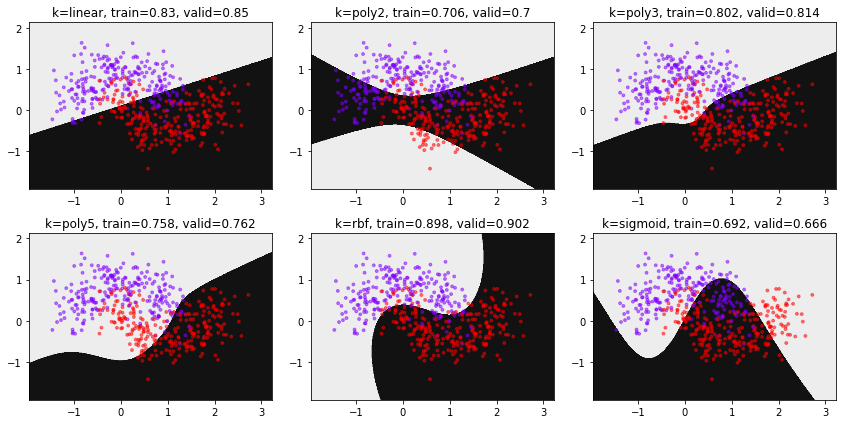

In [19]:
plt.figure(figsize=(12, 6))

for k, p, i in zip(("linear", "poly", "poly", "poly", "rbf", "sigmoid"), 
                   (0, 2, 3, 5, 0, 0), (1, 2, 3, 4, 5, 6)):
    _ = SVC(kernel=k, degree=p)
    _fit = _.fit(X_train, y_train)
    plt.subplot(2, 3, i)
    train_accuracy = accuracy_score(y_train, _.predict(X_train))
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    decision_boundary(X_valid, y_valid, _, soft=False, size=None, pointer_size=8, 
                      show=False, title="k={0}, train={1}, valid={2}".format(k+str(p) if p else k, 
                                                                             train_accuracy, valid_accuracy))

plt.tight_layout()
plt.show()

### Neural networks

[scikit-learn's guide on neural networks](http://scikit-learn.org/stable/modules/neural_networks_supervised.html)

[Wikipedia article on the multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)

Neural networks are multiple layers of multiple classifiers working together to classify data. This multi-layer approach makes neural networks extremely non-linear.

Here we use the [`MLPClassifier()`](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), which is the "classic" feed forward neural network. scikit-learn includes some options by default, such as the [ReLU](https://en.wikipedia.org/wiki/Rectifier_&lpar;neural_networks&rpar;) activation function, the [Adam optimizer](http://ruder.io/optimizing-gradient-descent/index.html#adam), [L2](https://stats.stackexchange.com/a/45644) regularization of 0.0001, and [momentum](http://cs231n.github.io/neural-networks-3/#sgd) of 0.9.

Interesting arguments for `MLPClassifier`
* `hidden_layer_sizes` determines the size of the hidden layers, for example (25, 10, ) will create a network with a hidden layer of size 25, then of size 10, and then an output layer as appropriate for the data.
* `activation` determines the activation function used throughout the hidden layers. By default this is `'relu'`.
* `solver` gives the choice of the "classic" gradient descent methods SGD and Adam, but also the quasi-Newton LBFGS.
* `alpha` sets the L2 regularization and is enabled by default

/home/toaster/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


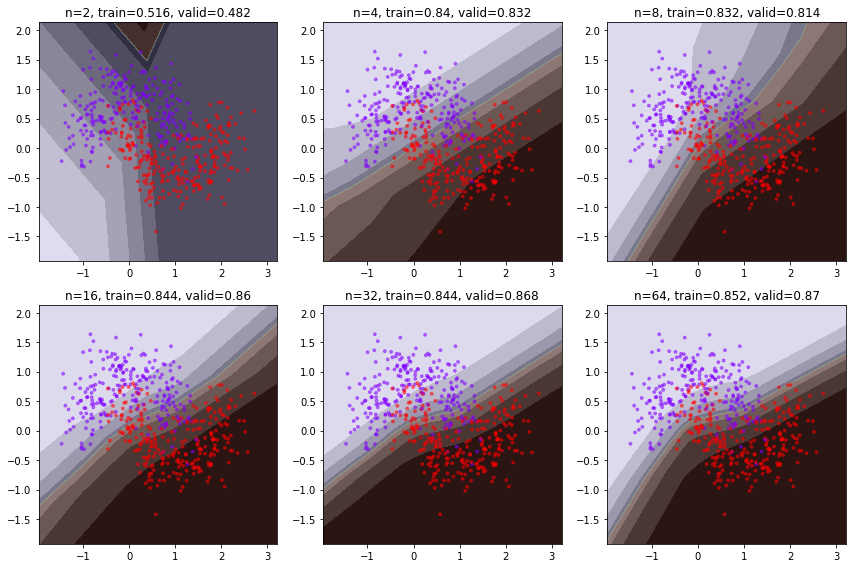

CPU times: user 10.2 s, sys: 392 ms, total: 10.6 s
Wall time: 3.66 s


In [20]:
%%time

plt.figure(figsize=(12, 8))

for n, i in zip((2, 4, 8, 16, 32, 64), (1, 2, 3, 4, 5, 6)):
    _ = MLPClassifier(hidden_layer_sizes=(n,), activation="relu", solver="adam", alpha=0.0001, momentum=0.9)
    _fit = _.fit(X_train, y_train)
    plt.subplot(2, 3, i)
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    train_accuracy = accuracy_score(y_train, _.predict(X_train))
    decision_boundary(X_valid, y_valid, _, size=None, pointer_size=8, 
                      show=False, title="n={0}, train={1}, valid={2}".format(n, train_accuracy, valid_accuracy))

plt.tight_layout()
plt.show()

The power of neural networks come from their layers: the more layers, the more non-linearity. You can see below how adding extra hidden layers helps the model adapt a lot faster.

/home/toaster/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


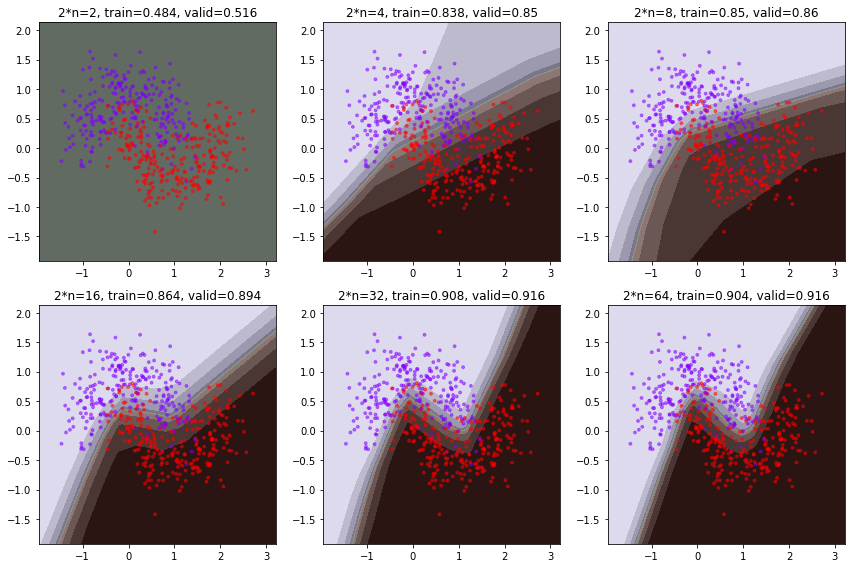

CPU times: user 16.3 s, sys: 739 ms, total: 17 s
Wall time: 5.36 s


In [21]:
%%time

plt.figure(figsize=(12, 8))

for n, i in zip((2, 4, 8, 16, 32, 64), (1, 2, 3, 4, 5, 6)):
    _ = MLPClassifier(hidden_layer_sizes=(n,n,), activation="relu", solver="adam", alpha=0.0001, momentum=0.9)
    _fit = _.fit(X_train, y_train)
    plt.subplot(2, 3, i)
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    train_accuracy = accuracy_score(y_train, _.predict(X_train))
    decision_boundary(X_valid, y_valid, _, size=None, pointer_size=8, 
                      show=False, title="2*n={0}, train={1}, valid={2}".format(n, train_accuracy, valid_accuracy))

plt.tight_layout()
plt.show()

I hope this proved an interesting introduction to classifiers in scikit-learn!

## Appendix: setting up classification data

When you're running data with classes, you want them to be in the format `0 False` and `1 True`, which is what the classifiers like; however, it's not always obvious how to transform your data this way. I'll show you a few tricks on how to do it.

Classification often shows up as binary classification and multi-class classification.

If you're testing whether apples are fresh or not, you would want `0 = 'not fresh'` and `1 = 'fresh'`. This is known as [binary classification](https://en.wikipedia.org/wiki/Binary_classification). Binary classes can also appear as $X$ variables.

In another instance, you may be classifying into multiple classes, such as predicting the color of apples. In this case you would want `(1,0,0) = red`, `(0,1,0) = yellow`, and `(0,0,1) = green`: all the numbers as $0$ except for the `True` class. These are known as [one-hot vectors](https://en.wikipedia.org/wiki/One-hot). They too can appear as $X$ variables.

### Binary coding by testing condition

You can transform data into 1s and 0s by testing them against a condition. This is done with numpy's [`np.where()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) function.

`np.where()`'s syntax is `np.where(<boolean array-like>, value when True, value when False)`.

In [22]:
source_data = np.array(["green", "red", "yellow", "red", "blue"])

# Just to show you that this does indeed output a boolean array
print(source_data == "red")

# Using np.where()
print(np.where(source_data == "red", 1, 0))

# Reshape it for use in a model
print(np.where(source_data == "red", 1, 0).reshape((-1,1)))

[False  True False  True False]
[0 1 0 1 0]
[[0]
 [1]
 [0]
 [1]
 [0]]


This technique also works with numeric data and more complex conditions; however, you need to use the [`np.logical_or()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.logical_or.html) function here. You can find the other numpy logical operators [here](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.logic.html#logical-operations).

In [23]:
source_data = np.array([1.2, 4.6, -3.2, 6.1, -0.1])

print(np.where(np.logical_or(source_data > 5, source_data < 0), 1, 0).reshape((-1,1)))

[[0]
 [0]
 [1]
 [1]
 [1]]


### Multi-class with or without IDs

When dealing with mutliple classes, you might not have the IDs ready. But as long as you're able to setup a `label_2_id` dictionary (given a label, returns an ID number) and an `id_2_label` list (given an integer, retrieve label as the index), you'll be able to switch between label and one-hot vector at will.

Basically, you want to set up a system for converting back and forth between label and ID (the IDs being what you use for modeling).

Before anything else, we do need to figure out the number of classes we have. This can be done with the [`set`](https://docs.python.org/3/tutorial/datastructures.html#sets) datatype. It's basically a python dictionary without keys, but this ends up useful since it eliminates all duplicates.

#### id_2_label

If you convert the `set` into a `list` with the [`list()`](https://docs.python.org/3/library/functions.html#func-list) function, you effectively create the `id_2_label` list. All it is now is a list of unique labels. I found this [clever technique on Stack Overflow](https://stackoverflow.com/a/37323404).

#### label_2_id

To create the `label_2_id` dictionary we take advantage of the [`dict()`](https://docs.python.org/3/library/stdtypes.html#dict) function for creating dictionaries. It lets you assign a dicionary by bulk. We feed the unique labels as the `keys` and a `range()` as the `values`. That creates the `label_2_id` dictionary nicely.

(In case I've never explained the [`range()`](https://docs.python.org/3/library/functions.html#func-range) function, it returns a list of incrementing integers.)

#### one-hot vectors

To create one-hot vectors, you can use the [`np.eye()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.eye.html).

The `np.eye()` function creates diagonal matrices, so how does this work? You can take advantage of numpy's indexing to index by the ID number of each data point. Since an ID number $k$ is an integer, it will select row $k$ of the diagonal matrix, which happens to also be the one-hot

In [24]:
source_data = [1, 2, 4, 8, 2, 4, 6, 8, 1, 2]

# This is what a set is like
print(set(source_data))

set_data = set(source_data)

# Now we can know the number of classes
n_classes = len(set_data)

# It's a good idea to have a way of converting back from IDs
id_2_label = list(set_data)

# We pull off another trick to assign IDs to the classes
label_2_id = dict(zip(set_data, range(n_classes)))

# We assign the IDs
id_data = [label_2_id[x] for x in source_data]

one_hots = np.eye(n_classes)[id_data]
print(one_hots)

{1, 2, 4, 6, 8}
[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]]


When you want to convert back from one-hot vectors into labels, you can use the `np.argmax()` function.

In [25]:
# I have a list comprehension addiction
print([id_2_label[x] for x in np.argmax(one_hots, axis=1)])

[1, 2, 4, 8, 2, 4, 6, 8, 1, 2]
